C:\Users\saul7\AppData\Local\Temp\ipykernel_24724\3026237852.py:5: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  glacier_df = pd.read_csv('glacier.csv')


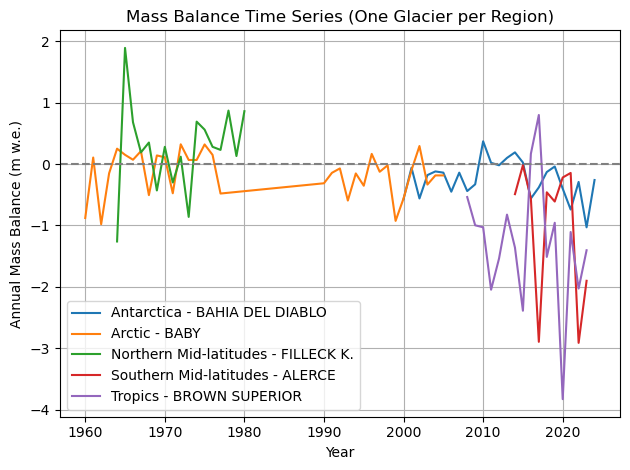

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# Load glacier metadata (IDs, names, lat/lon)
glacier_df = pd.read_csv('glacier.csv')

# Load annual mass balance data (includes annual measurements per glacier)
mass_balance_df = pd.read_csv('mass_balance.csv')

# Rename 'id' to 'glacier_id' to match key in mass_balance_df
glacier_df = glacier_df.rename(columns={'id': 'glacier_id'})

# Merge the two datasets using glacier_id to combine location + balance data
merged_df = pd.merge(glacier_df, mass_balance_df, on='glacier_id')

# Remove any rows missing necessary geospatial or measurement data
merged_df = merged_df.dropna(subset=['latitude', 'longitude', 'annual_balance', 'year'])

# Define a function to classify glaciers into latitude-based regions
def classify_region(lat):
    if lat > 60:
        return 'Arctic'
    elif lat > 0:
        return 'Northern Mid-latitudes'
    elif lat > -30:
        return 'Tropics'
    elif lat > -60:
        return 'Southern Mid-latitudes'
    else:
        return 'Antarctica'

# Apply region classification to each glacier based on its latitude
merged_df['region'] = merged_df['latitude'].apply(classify_region)

# Prepare a list to store one representative glacier per region
glaciers_by_region = []

# Group the dataset by region
for region, group in merged_df.groupby('region'):
    
    # Filter glaciers that have data for at least 10 unique years
    candidates = group.groupby('glacier_id').filter(lambda g: g['year'].nunique() >= 10)
    
    if not candidates.empty:
        # Choose the first qualifying glacier
        glacier_id = candidates['glacier_id'].iloc[0]
        glacier_name = candidates[candidates['glacier_id'] == glacier_id]['glacier_name'].iloc[0]
        glacier_data = candidates[candidates['glacier_id'] == glacier_id]
        
        # Save region, glacier name, and its data for plotting
        glaciers_by_region.append((region, glacier_name, glacier_data))


# Plot each glacier's mass balance data as a separate line
for region, name, data in glaciers_by_region:
    data = data.sort_values('year')  # Ensure years are in order
    label = f"{region} - {name}"     # e.g. "Arctic - Devon Ice Cap"
    plt.plot(data['year'], data['annual_balance'], label=label)

# Add titles, labels, and reference line
plt.title('Mass Balance Time Series (One Glacier per Region)')
plt.xlabel('Year')
plt.ylabel('Annual Mass Balance (m w.e.)')
plt.axhline(0, color='gray', linestyle='--')  # Zero balance line
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

What is Annual Mass Balance?
    Mass balance refers to the net gain or loss of ice on a glacier in a given year.
______________________________________________________________________________________________
It’s measured in meters water equivalent (m w.e.), which means how much the glacier gained or lost in terms of water volume.
Positive values (above 0): The glacier gained ice that year (more snow accumulation than melt).

Negative values (below 0): The glacier lost ice (more melting than snow accumulation).
______________________________________________________________________________________________
The dashed horizontal line at 0 separates gain from loss:

    Lines mostly below 0: Glacier is generally shrinking.

    Lines mostly above 0: Glacier is generally growing (less common).

